In [6]:
% matplotlib inline

from __future__ import division

import glob
import numpy as np
from collections import namedtuple
from fractions import Fraction

import colour
from colour.plotting import *

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_DDFAPD)
from colour_hdri.exif import get_exif_data
from colour_hdri.merge import merge_to_hdri
from colour_hdri.weighting_functions import (
    hat_function,
    normal_distribution_function,
    weighting_function_Debevec1997)


DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/NIKON D800/Nice_002/Panorama/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

ExifData = namedtuple('ExifData', ('aperture', 'shutter_speed', 'iso'))

Image = namedtuple('Image', ('path', 'data', 'exif_data'))


def batch(iterable, size):
    """
    Creates batches of given size using given iterable.
    :param iterable: iterable.
    :type iterable: unicode or unicode or tuple or list or dict
    :param size: Batches size.
    :type size: int
    :return: Batches.
    :rtype: list
    """

    return [iterable[i: i + size] for i in range(0, len(iterable), size)]


def process1(dng_files):
    print('Reading Images...')
    images = []
    for dng_file in dng_files:
        exif_data = get_exif_data(dng_file)
        aperture = float(exif_data['EXIF']['Aperture Value'][0])
        shutter_speed = float(Fraction(
            exif_data['EXIF']['Shutter Speed Value'][0]))
        iso = float(exif_data['EXIF']['ISO'][0])

        images.append(Image(dng_file,
                            colour.read_image(dng_file.replace('dng', 'tiff')),
                            ExifData(aperture, shutter_speed, iso)))
        
    return images


DNG_FILES = batch(glob.glob('{0}/*.dng'.format(DIRECTORY)), 9)

IMAGES = process1(DNG_FILES[1])

Reading Images...


In [7]:
def process2(images, black_level=None, white_level=None):
    
    if black_level is None:
        black_level = 0

    if white_level is None:
        white_level = 0
        for image in images:
            white_level = max(white_level, np.max(image.data))

    # TODO: Need a mutable data structure here.
    scaled_images = []
    for image in images:
        data = image.data - black_level
        data *= 1 / white_level

        scaled_images.append(Image(image.path, data, image.exif_data))
    
    return scaled_images
        
IMAGES = process2(IMAGES)

Merging Images...


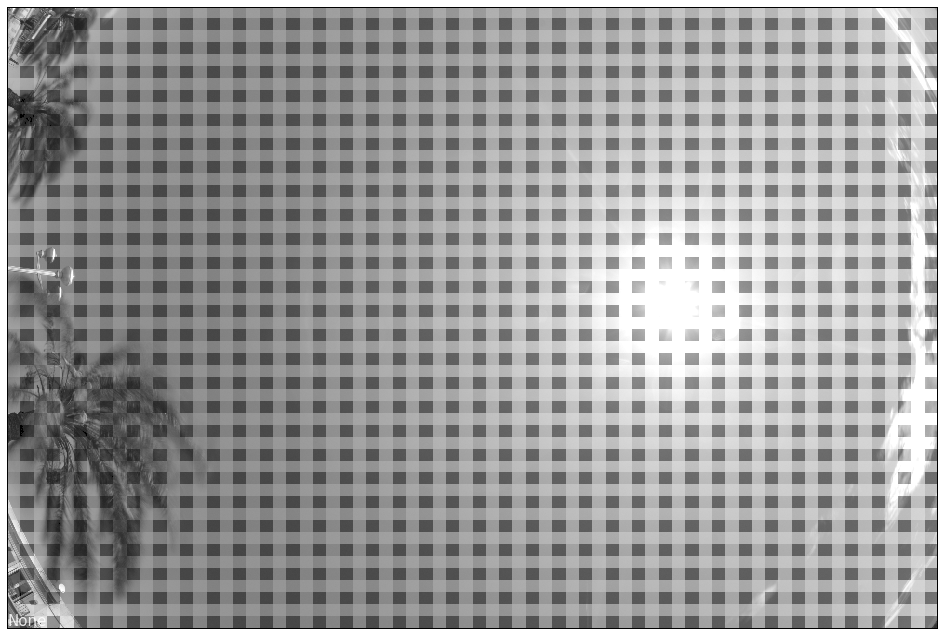

In [8]:
def custom_weight_function(a):
    a = np.asarray(a)

    return np.where(a < 0.5,
                   weighting_function_Debevec1997(a),
                   1)


def process3(images):
    print('Merging Images...')
    image = merge_to_hdri(images, custom_weight_function)

    image_plot(OECF(colour.tstack((image, image, image))))
    
    return image

IMAGE = process3(IMAGES)

Debayering Image...


/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour/models/dataset/srgb.py:111: RuntimeWarning: invalid value encountered in power
  1.055 * (value ** (1 / 2.4)) - 0.055)


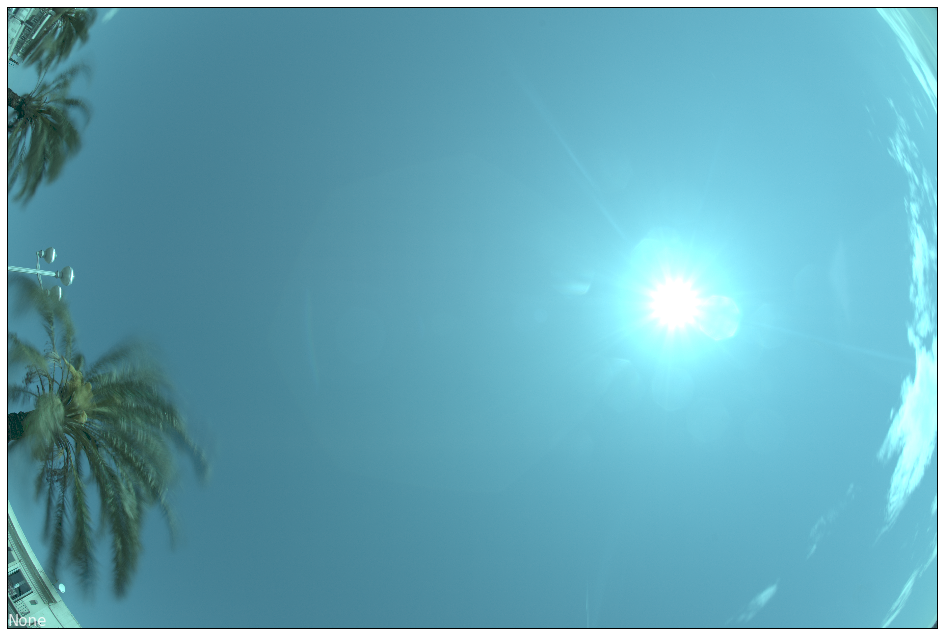

array([[[ 0.12696439,  0.32918711,  0.31627377],
        [ 0.1160355 ,  0.32437008,  0.30608056],
        [ 0.12899075,  0.3434372 ,  0.32379776],
        ..., 
        [ 0.09470063,  0.31237802,  0.34501884],
        [ 0.09638663,  0.31314695,  0.34467035],
        [ 0.10633855,  0.32309887,  0.35357367]],

       [[ 0.11235207,  0.31933856,  0.30104905],
        [ 0.12083185,  0.33039318,  0.31210366],
        [ 0.13003943,  0.34544275,  0.32502036],
        ..., 
        [ 0.09400302,  0.3111247 ,  0.34376552],
        [ 0.09658059,  0.31324071,  0.34479852],
        [ 0.1042022 ,  0.32094131,  0.35141611]],

       [[ 0.12965025,  0.34140052,  0.32173831],
        [ 0.12767301,  0.34172825,  0.32023131],
        [ 0.13412847,  0.35048866,  0.32992   ],
        ..., 
        [ 0.08921367,  0.3064893 ,  0.33816184],
        [ 0.09631164,  0.31287155,  0.344127  ],
        [ 0.09971639,  0.3162763 ,  0.34691121]],

       ..., 
       [[ 0.06011751,  0.15596943,  0.15079886],
        

In [11]:
def process4(CFA):
    print('Debayering Image...')
    image = demosaicing_CFA_Bayer_DDFAPD(CFA)

    colour.write_image(image, '{0}/DSC_2482_9.exr'.format(DIRECTORY))

#     image = demosaicing_CFA_Bayer_Malvar2004(CFA)

#     colour.write_image(image, '{0}/Merge_Malvar2004.exr'.format(DIRECTORY))

#     image = demosaicing_CFA_Bayer_DDFAPD(CFA)

#     colour.write_image(image, '{0}/Merge_Menon2007.exr'.format(DIRECTORY))
                       
    image_plot(OECF(image))
    
    return image

process4(IMAGE)

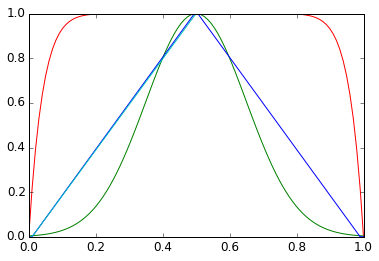

In [10]:
import pylab

pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)), label='Hat')
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)), label='Normal')
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec1997(np.linspace(0, 1, 100)), label='Debevec (1997)')
pylab.plot(np.linspace(0, 1, 1000), custom_weight_function(np.linspace(0, 1, 1000)), label='Custom')

pylab.show()